# Import Libraries

library Python yang digunakan dalam proyek ini, antara lain:

- **math, numpy, pandas, xarray** → untuk komputasi matematis dan manipulasi data

- **seaborn, matplotlib.pyplot** → untuk visualisasi data

- **lowess dari statsmodels** → untuk smoothing data

- **tsmoothie** → untuk smoothing time series

- **scipy.signal.savgol_filter** → untuk filtering data

- **IsolationForest dari sklearn** → untuk deteksi outlier

- **MinMaxScaler, mean_squared_error** → untuk normalisasi dan evaluasi error

- **keras dan tensorflow.keras** → untuk membangun model LSTM neural network

In [1]:
import math
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from tsmoothie import *
from scipy.signal import savgol_filter
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2



# Create The Function


Fungsi-fungsi digunakan untuk memuat, memproses, dan mengevaluasi data:

* **`load_data(filepath)`**
  Memuat data dari file NetCDF, memilih area spasial (lat, lon) dan periode waktu tertentu (2020–2025), menambahkan koordinat baru seperti tahun, bulan, hari, dan menghitung rata-rata spasial harian. Output berupa dataset yang sudah diproses harian.

* **`create_dataframe(variables_dict)`**
  Mengubah beberapa dataset (dalam bentuk dictionary) menjadi DataFrame pandas, membuat kolom tanggal, dan menggabungkan semuanya berdasarkan kolom waktu (`time`).

* **`prepare_data(data, batch_size)`**
  Membentuk data input (X) dan target (y) untuk model, menggunakan pendekatan jendela geser (*sliding window*) sepanjang `batch_size`. Data diubah menjadi array NumPy dengan dimensi yang sesuai untuk input ke model LSTM.

* **`rmse_calculation(y_data, y_pred)`**
  Menghitung Root Mean Square Error (RMSE) untuk masing-masing variabel (seperti swh, hmax, mp2, dll.) antara data aktual dan hasil prediksi, lalu mencetak skor RMSE untuk masing-masing.

In [2]:
# Function to load data from a NetCDF file
def load_data(filepath):
    min_lat, max_lat = -8.50, -8.50
    min_lon, max_lon = 110, 110.50
    ds = xr.open_dataset(filepath, engine='netcdf4', decode_cf=True)
    ds = ds.sel(lat=slice(max_lat, min_lat), lon=slice(min_lon, max_lon))
    ds = ds.sel(time=slice('2020-01-01', '2025-03-31'))

    ds = ds.assign_coords(
        year=('time', ds.time.dt.year.values),
        month=('time', ds.time.dt.month.values),
        day=('time', ds.time.dt.day.values),
        dayofyear=('time', ds.time.dt.dayofyear.values))
    
    ds_spatial_mean = ds.mean(dim=['lat', 'lon'])
    ds_daily_mean = ds_spatial_mean.resample(time='1D').mean()
    data_strings = [pd.Timestamp(t).strftime('%Y-%m-%d') for t in ds_daily_mean.time.values]
    ds_daily_mean = ds_daily_mean.assign_coords(date=('time',data_strings))

    return ds_daily_mean

# Function to create a DataFrame from the dataset
def create_dataframe(variables_dict):
    dataframes = {}
    # Convert each dataset to DataFrame
    for var_name, dataset in variables_dict.items():
        df = dataset.to_dataframe().reset_index()
        df['date'] = df['time'].dt.strftime('%Y-%m-%d')
        # Save DataFrame with only the required columns
        dataframes[var_name] = df[['time', var_name]]
    
    # Start with the first DataFrame that has time and date columns
    base_df = list(variables_dict.items())[0][1].to_dataframe().reset_index()
    base_df['date'] = base_df['time'].dt.strftime('%Y-%m-%d')
    base_df = base_df[['time', 'date', list(variables_dict.keys())[0]]]

    # Merge all DataFrames on 'time' column
    for var_name in list(variables_dict.keys())[1:]:
        base_df = base_df.merge(dataframes[var_name], on='time', how='outer')
    
    return base_df

# Function to preprocess the data
def prepare_data(data, batch_size):
    x_list = []
    y_list = []

    for i in range(len(data)-batch_size-1):
        x_list.append(data[i:i+batch_size])
        y_list.append(data[i+batch_size+1])

    X_data = np.array(x_list)
    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[2], X_data.shape[1]))
    y_data = np.array(y_list)

    return X_data, y_data

# RSME function
def rmse_calculation(y_data, y_pred):
    swh_score = math.sqrt(mean_squared_error(y_data[:, 4], y_pred[:, 4]))
    hmax_score = math.sqrt(mean_squared_error(y_data[:, 0], y_pred[:, 0]))
    mp2_score = math.sqrt(mean_squared_error(y_data[:, 1], y_pred[:, 1]))
    pp1d_score = math.sqrt(mean_squared_error(y_data[:, 3], y_pred[:, 3]))
    mwd_score = math.sqrt(mean_squared_error(y_data[:, 2], y_pred[:, 2]))
    sst_score = math.sqrt(mean_squared_error(y_data[:, 5], y_pred[:, 5]))

    print('RMSE of swh:', swh_score)
    print('RMSE of hmax:', hmax_score)
    print('RMSE of mp2:', mp2_score)
    print('RMSE of pp1d:', pp1d_score)
    print('RMSE of mwd:', mwd_score)
    print('RMSE of sst:', sst_score)

# Data Preparation

**Data yang digunakan dalam proyek ini memiliki fitur-fitur berikut:**

* **Date** : Tanggal (catatan rata-rata harian gelombang)
* **Hmax** : Tinggi (dalam meter) dari satu gelombang tertinggi.
* **mp2** : Rata-rata periode gelombang zero up-crossing, dalam detik.
* **mwd** : Arah rata-rata datangnya gelombang, ditunjukkan dalam derajat dari arah utara sejati.
* **pp1d** : Periode gelombang (dalam detik) dari gelombang yang menghasilkan energi terbesar dalam satu catatan gelombang.
* **swh** : Tinggi gelombang signifikan (dalam meter) yang mencakup gelombang angin dan swell.
* **sst** : Suhu permukaan laut di pelampung pemantau gelombang, dalam derajat Celsius.


In [3]:
# Define the path to the dataset directory
hmax = load_data(r'dataset\all_dataset\ERA5_reanalysis_hmax_01012020-17042025.nc')
mp2 = load_data(r'dataset\all_dataset\ERA5_reanalysis_mp2_01012020-17042025.nc')
mwd = load_data(r'dataset\all_dataset\ERA5_reanalysis_mwd_01012020-18042025.nc')
pp1d = load_data(r'dataset\all_dataset\ERA5_reanalysis_pp1d_01012020-17042025.nc')
swh = load_data(r'dataset\all_dataset\ERA5_reanalysis_swh_01012020-17042025.nc')
sst = load_data(r'dataset\all_dataset\ERA5_reanalysis_sst_01012020-18042025.nc')


# Use the create_dataframe function to create the dataset
variables = {
    'hmax': hmax,
    'mp2': mp2,
    'mwd': mwd,
    'pp1d': pp1d,
    'swh': swh,
    'sst': sst
}
dataset = create_dataframe(variables).drop(columns=['time'])


In [4]:
dataset.head()

,date,hmax,mp2,mwd,pp1d,swh,sst
0,2020-01-01,4.387897,8.504220,202.299911,14.528440,2.387961,302.573151
1,2020-01-02,4.037947,6.604156,211.010391,12.881305,2.151537,302.379639
2,2020-01-03,4.329580,5.474380,232.269302,14.526120,2.290355,302.335693
3,2020-01-04,4.257541,6.209276,213.077377,12.971016,2.267563,302.436981
4,2020-01-05,4.291963,7.294424,195.956619,11.757617,2.309568,302.588806


Pada tahap ini melakukan pembersihan data dengan langkah-langkah berikut:

* Mengganti semua nilai `-99.90` dengan `NaN` sebagai penanda data hilang.
* Menghapus kolom `date` karena tidak diperlukan lagi.
* Menghapus seluruh baris yang mengandung `NaN` agar data bersih.
* Mereset indeks DataFrame agar urutan baris kembali rapih.
* Menampilkan 5 baris pertama data yang sudah dibersihkan dengan `.head()`.


In [5]:
# Drop rows with NaN values and reset the index
dataset.replace(-99.90, np.nan, inplace=True)
dataset.drop(columns=['date'], inplace=True)
dataset.dropna(inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset.head()

,hmax,mp2,mwd,pp1d,swh,sst
0,4.387897,8.504220,202.299911,14.528440,2.387961,302.573151
1,4.037947,6.604156,211.010391,12.881305,2.151537,302.379639
2,4.329580,5.474380,232.269302,14.526120,2.290355,302.335693
3,4.257541,6.209276,213.077377,12.971016,2.267563,302.436981
4,4.291963,7.294424,195.956619,11.757617,2.309568,302.588806


## Visualization of the Features

**Visualisasi awal data gelombang laut**

Cell ini menampilkan grafik garis untuk melihat pola dari 200 data pertama pada masing-masing variabel, dengan rincian sebagai berikut:

* Membuat subset data `df_graph` dari baris ke-0 sampai ke-200.

* Membuat figure dengan ukuran besar (15 x 22 inci) agar semua subplot terlihat jelas.

* Membuat 6 subplot (2 kolom, 6 baris) untuk masing-masing variabel:

  1. **Significant Wave Height (swh)** → warna biru
  2. **Maximum Wave Height (hmax)** → warna merah
  3. **Zero Upcrossing Wave Period (mp2)** → warna oranye
  4. **The Peak Energy Wave Period (pp1d)** → warna cokelat
  5. **Direction Related to True North (mwd)** → warna ungu
  6. **Sea Surface Temperature (sst)** → warna hijau

* Setiap subplot dilengkapi dengan judul untuk mempermudah identifikasi variabel yang ditampilkan.


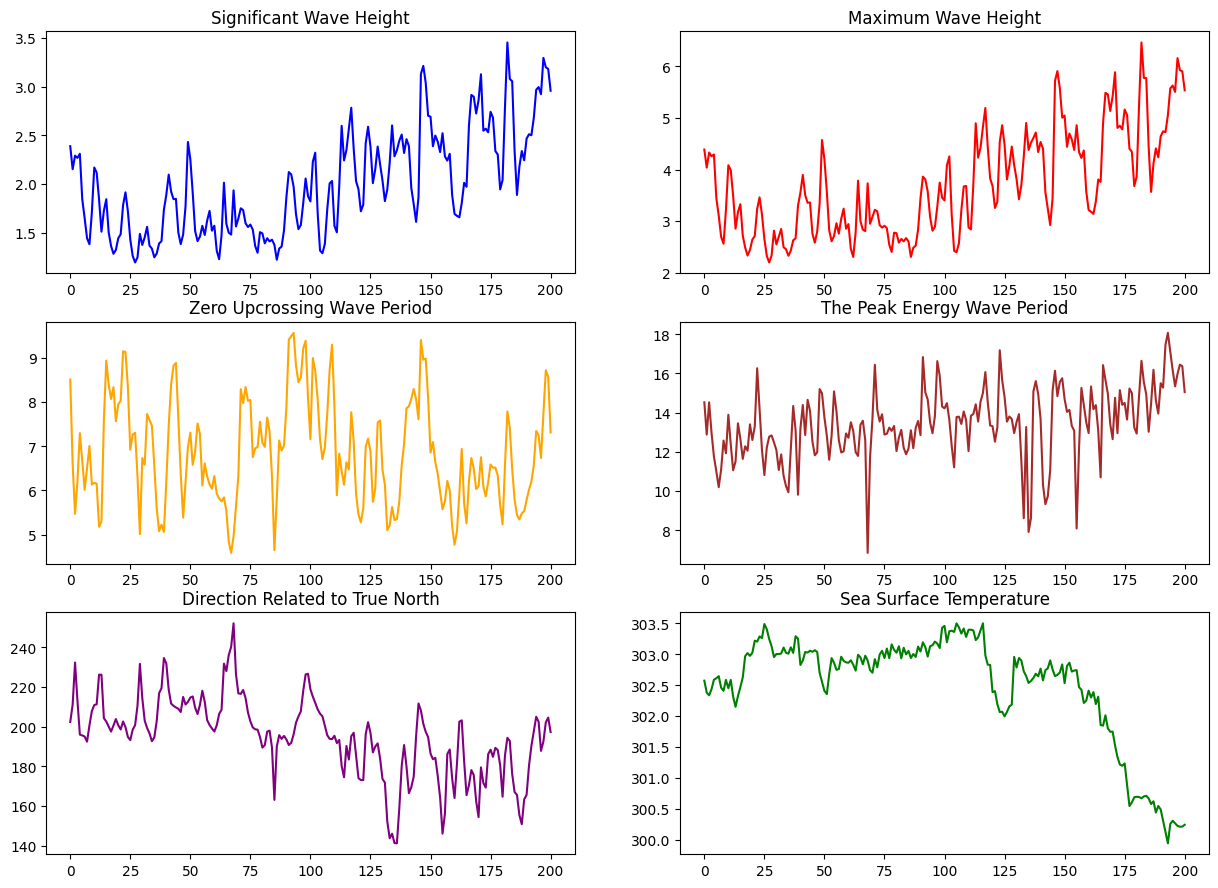

In [6]:
df_graph = dataset.loc[0:200]

plt.figure(figsize=(15,22))
plt.subplot(6,2,1)
plt.plot(df_graph['swh'], color='blue')
plt.title('Significant Wave Height')

plt.subplot(6,2,2)
plt.plot(df_graph['hmax'], color='red')
plt.title('Maximum Wave Height')

plt.subplot(6,2,3)
plt.plot(df_graph['mp2'], color='orange')
plt.title('Zero Upcrossing Wave Period')

plt.subplot(6,2,4)
plt.plot(df_graph['pp1d'], color='brown')
plt.title('The Peak Energy Wave Period')

plt.subplot(6,2,5)
plt.plot(df_graph['mwd'], color='purple')
plt.title('Direction Related to True North')

plt.subplot(6,2,6)
plt.plot(df_graph['sst'], color='green')
plt.title('Sea Surface Temperature')
plt.show();

## Reduce the Data Noise

Kelas `OceanWaveNoiseReduction` dirancang untuk mengelola pengurangan noise pada data deret waktu gelombang laut. Kelas ini menyediakan berbagai metode untuk memproses data, seperti memuat data dari file, mendeteksi dan menghapus anomali menggunakan algoritma Isolation Forest, serta menerapkan teknik pengurangan noise seperti rata-rata bergerak, perataan eksponensial, filter Savitzky-Golay, dan smoothing LOWESS. Selain itu, kelas ini juga mendukung pengurangan noise adaptif berdasarkan karakteristik kolom data. Semua metode tersebut dapat digunakan untuk menghasilkan data gelombang laut yang lebih halus dan bebas gangguan. Pengguna dapat memvisualisasikan hasil pemrosesan melalui grafik yang memperlihatkan perbandingan antara data asli dan data yang sudah dibersihkan.


In [7]:
class OceanWaveNoiseReduction:
    """
    A class for handling noise reduction in ocean wave time series data
    with multiple techniques optimized for oceanographic measurements.
    """
    
    def __init__(self, df=None):
        """Initialize with optional dataframe"""
        self.df = df
        self.df_cleaned = None
        self.anomaly_indices = {}
        
    def load_data(self, file_path, date_column=None, index_col=None):
        """Load time series data from file"""
        if file_path.endswith('.csv'):
            self.df = pd.read_csv(file_path, index_col=index_col, parse_dates=[date_column] if date_column else None)
        elif file_path.endswith(('.xls', '.xlsx')):
            self.df = pd.read_excel(file_path, index_col=index_col, parse_dates=[date_column] if date_column else None)
        else:
            raise ValueError("Unsupported file format. Please use CSV or Excel.")
        return self.df
    
    def detect_anomalies(self, columns=None, contamination=0.05):
        """
        Detect anomalies in the data using Isolation Forest
        
        Parameters:
        columns (list): List of column names to check for anomalies
        contamination (float): The proportion of outliers in the data set
        """
        if self.df is None:
            raise ValueError("No data loaded. Please load data first.")
            
        columns = columns if columns else self.df.columns
        self.anomaly_indices = {}
        
        for col in columns:
            if col in self.df.columns:
                # Reshape for Isolation Forest
                X = self.df[col].values.reshape(-1, 1)
                
                # Find NaN values
                nan_mask = np.isnan(X).flatten()
                
                # Only process non-NaN values
                valid_indices = np.where(~nan_mask)[0]
                valid_X = X[~nan_mask].reshape(-1, 1)
                
                if len(valid_X) > 0:
                    # Apply Isolation Forest
                    iso = IsolationForest(contamination=contamination, random_state=42)
                    yhat = iso.fit_predict(valid_X)
                    
                    # Map back to original indices
                    anomalies = valid_indices[yhat == -1]
                    self.anomaly_indices[col] = anomalies
                    
                    print(f"Detected {len(anomalies)} anomalies in column '{col}'")
                else:
                    print(f"Warning: Column '{col}' contains only NaN values")
        
        return self.anomaly_indices
    
    def remove_anomalies(self, columns=None, method='interpolate'):
        """
        Remove detected anomalies from the data
        
        Parameters:
        columns (list): List of column names to clean
        method (str): Method to replace anomalies ('interpolate', 'mean', or 'median')
        """
        if self.df is None:
            raise ValueError("No data loaded. Please load data first.")
            
        if not self.anomaly_indices:
            self.detect_anomalies(columns)
            
        # Create a copy of the dataframe
        self.df_cleaned = self.df.copy()
        
        for col, indices in self.anomaly_indices.items():
            if len(indices) > 0:
                # Create a mask for the anomalies
                mask = np.zeros(len(self.df_cleaned), dtype=bool)
                mask[indices] = True
                
                # Store original values
                original_values = self.df_cleaned.loc[mask, col].copy()
                
                # Replace anomalies based on the chosen method
                if method == 'interpolate':
                    self.df_cleaned.loc[mask, col] = np.nan
                    self.df_cleaned[col] = self.df_cleaned[col].interpolate(method='cubic')
                    # Handle edge cases
                    self.df_cleaned[col] = self.df_cleaned[col].fillna(method='ffill').fillna(method='bfill')
                elif method == 'mean':
                    self.df_cleaned.loc[mask, col] = self.df_cleaned[col].mean()
                elif method == 'median':
                    self.df_cleaned.loc[mask, col] = self.df_cleaned[col].median()
                else:
                    raise ValueError("Method not recognized. Use 'interpolate', 'mean', or 'median'.")
                
                print(f"Replaced {len(indices)} anomalies in column '{col}' using {method} method")
        
        return self.df_cleaned
    
    def apply_moving_average(self, columns=None, window=5):
        """Apply simple moving average smoothing"""
        if self.df is None:
            raise ValueError("No data loaded. Please load data first.")
            
        df_result = self.df_cleaned.copy() if self.df_cleaned is not None else self.df.copy()
        columns = columns if columns else df_result.columns
        
        for col in columns:
            if col in df_result.columns:
                df_result[f"{col}_ma"] = df_result[col].rolling(window=window, center=True).mean()
                # Handle NaN values at edges
                df_result[f"{col}_ma"] = df_result[f"{col}_ma"].fillna(df_result[col])
                
        return df_result
    
    def apply_exponential_smoothing(self, columns=None, alpha=0.3):
        """Apply exponential smoothing"""
        if self.df is None:
            raise ValueError("No data loaded. Please load data first.")
            
        df_result = self.df_cleaned.copy() if self.df_cleaned is not None else self.df.copy()
        columns = columns if columns else df_result.columns
        
        for col in columns:
            if col in df_result.columns:
                df_result[f"{col}_ema"] = df_result[col].ewm(alpha=alpha, adjust=False).mean()
                
        return df_result
    
    def apply_savitzky_golay(self, columns=None, window=15, polyorder=3):
        """
        Apply Savitzky-Golay filter for smoothing
        Particularly effective for wave height data
        """
        if self.df is None:
            raise ValueError("No data loaded. Please load data first.")
            
        df_result = self.df_cleaned.copy() if self.df_cleaned is not None else self.df.copy()
        columns = columns if columns else df_result.columns
        
        for col in columns:
            if col in df_result.columns:
                # Handle NaN values
                data = df_result[col].copy()
                mask = data.isna()
                if mask.any():
                    # Temporarily fill NaNs for filtering
                    data = data.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
                
                # Apply Savitzky-Golay filter
                filtered_data = savgol_filter(data, window, polyorder)
                
                # Restore NaN values
                filtered_series = pd.Series(filtered_data, index=df_result.index)
                if mask.any():
                    filtered_series[mask] = np.nan
                    
                df_result[f"{col}_sg"] = filtered_series
                
        return df_result
    
    def apply_lowess(self, columns=None, frac=0.1):
        """
        Apply LOWESS (Locally Weighted Scatterplot Smoothing)
        Good for nonlinear trends in wave direction data
        """
        if self.df is None:
            raise ValueError("No data loaded. Please load data first.")
            
        df_result = self.df_cleaned.copy() if self.df_cleaned is not None else self.df.copy()
        columns = columns if columns else df_result.columns
        
        for col in columns:
            if col in df_result.columns:
                # Handle NaN values
                data = df_result[col].copy()
                mask = data.isna()
                if mask.any():
                    # Temporarily fill NaNs for filtering
                    data = data.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
                
                # Create x values (indices)
                x = np.arange(len(data))
                
                # Apply LOWESS smoothing
                smoothed = lowess(data, x, frac=frac)
                
                # Extract the smoothed values
                smoothed_data = smoothed[:, 1]
                
                # Restore NaN values
                smoothed_series = pd.Series(smoothed_data, index=df_result.index)
                if mask.any():
                    smoothed_series[mask] = np.nan
                    
                df_result[f"{col}_lowess"] = smoothed_series
                
        return df_result
    
   
    
    def adaptive_noise_reduction(self, columns=None):
        """
        Apply an adaptive noise reduction strategy based on the characteristics of each column
        """
        if self.df is None:
            raise ValueError("No data loaded. Please load data first.")
            
        df_result = self.df_cleaned.copy() if self.df_cleaned is not None else self.df.copy()
        columns = columns if columns else df_result.columns
        
        for col in columns:
            if col in df_result.columns:
                # Analyze the time series characteristics
                data = df_result[col].copy()
                
                # Skip if too many NaN values
                if data.isna().sum() > 0.5 * len(data):
                    print(f"Skipping column '{col}' due to excessive missing values")
                    continue
                
                # For wave height and temperature, Savitzky-Golay works well
                window = min(15, len(data) // 10) if len(data) > 30 else 5
                window = window if window % 2 == 1 else window + 1  # Ensure odd window
                    
                # Apply Savitzky-Golay
                df_result = self.apply_savitzky_golay(columns=[col], window=window, polyorder=3)
                df_result[f"{col}_adaptive"] = df_result[f"{col}_sg"]
        return df_result
    
    def plot_results(self, df_processed, columns=None, methods=None, figsize=(15, 10)):
        """
        Plot original data along with cleaned/smoothed versions
        
        Parameters:
        df_processed (DataFrame): DataFrame with original and processed columns
        columns (list): List of original columns to plot
        methods (list): List of smoothing methods to display
        figsize (tuple): Figure size
        """
        if columns is None:
            # Get only the original columns (those without underscores)
            columns = [col for col in df_processed.columns if '_' not in col]
            
        if methods is None:
            # Get unique suffixes used for processed columns
            suffixes = set()
            for col in df_processed.columns:
                if '_' in col:
                    suffixes.add(col.split('_')[-1])
            methods = list(suffixes)
            
        n_cols = len(columns)
        fig, axes = plt.subplots(n_cols, 1, figsize=figsize, sharex=True)
        
        # Convert to axes array if there's only one subplot
        if n_cols == 1:
            axes = [axes]
            
        for i, col in enumerate(columns):
            # Plot original data
            axes[i].plot(df_processed.index if df_processed.index.dtype.kind != 'i' else range(len(df_processed)), 
                         df_processed[col], 'b-', alpha=0.5, label='Original')
            
            # Plot each processed version
            for method in methods:
                method_col = f"{col}_{method}"
                if method_col in df_processed.columns:
                    axes[i].plot(df_processed.index if df_processed.index.dtype.kind != 'i' else range(len(df_processed)), 
                                 df_processed[method_col], label=f'{method}')
            
            axes[i].set_title(col)
            axes[i].legend(loc='best')
            axes[i].grid(True)
            
        plt.tight_layout()
        return fig

    def process_all(self, columns=None, detect_anomalies=True, anomaly_method='interpolate'):
        """
        Process the entire dataframe with multiple noise reduction techniques
        
        Returns:
        DataFrame with all smoothed versions
        """
        if self.df is None:
            raise ValueError("No data loaded. Please load data first.")
            
        # Step 1: Remove anomalies if requested
        if detect_anomalies:
            self.detect_anomalies(columns)
            self.remove_anomalies(columns, method=anomaly_method)
            df_base = self.df_cleaned
        else:
            df_base = self.df
            
        # Step 2: Apply all smoothing techniques
        df_result = df_base.copy()
        
        # Apply each method
        methods = {
            'sg': lambda: self.apply_savitzky_golay(columns),
            'adaptive': lambda: self.adaptive_noise_reduction(columns)
        }
        
        for name, method_func in methods.items():
            try:
                df_temp = method_func()
                # Keep only the columns with the current method
                for col in df_temp.columns:
                    if f"_{name}" in col:
                        df_result[col] = df_temp[col]
            except Exception as e:
                print(f"Error applying method {name}: {e}")
                
        return df_result

# Dokumentasi Pemrosesan Data Gelombang Laut

**Fungsi:**
1. Mengurangi noise pada data gelombang laut menggunakan filter Savitzky-Golay
2. Memilih kolom tertentu yang sudah diolah

In [8]:
noicereducer = OceanWaveNoiseReduction(df=dataset)
dataset = noicereducer.apply_savitzky_golay()
dataset = dataset[['swh_sg', 'hmax_sg', 'mp2_sg', 'pp1d_sg', 'mwd_sg', 'sst_sg']]
dataset.head()

,swh_sg,hmax_sg,mp2_sg,pp1d_sg,mwd_sg,sst_sg
0,2.474415,4.601300,7.419082,14.726964,216.194916,302.454590
1,2.303036,4.289216,7.125723,13.704912,210.855911,302.462372
2,2.161165,4.031844,6.875417,12.916752,206.853226,302.474976
3,2.046052,3.823894,6.665782,12.337415,204.065414,302.490204
4,1.954948,3.660075,6.494435,11.941835,202.371002,302.505890


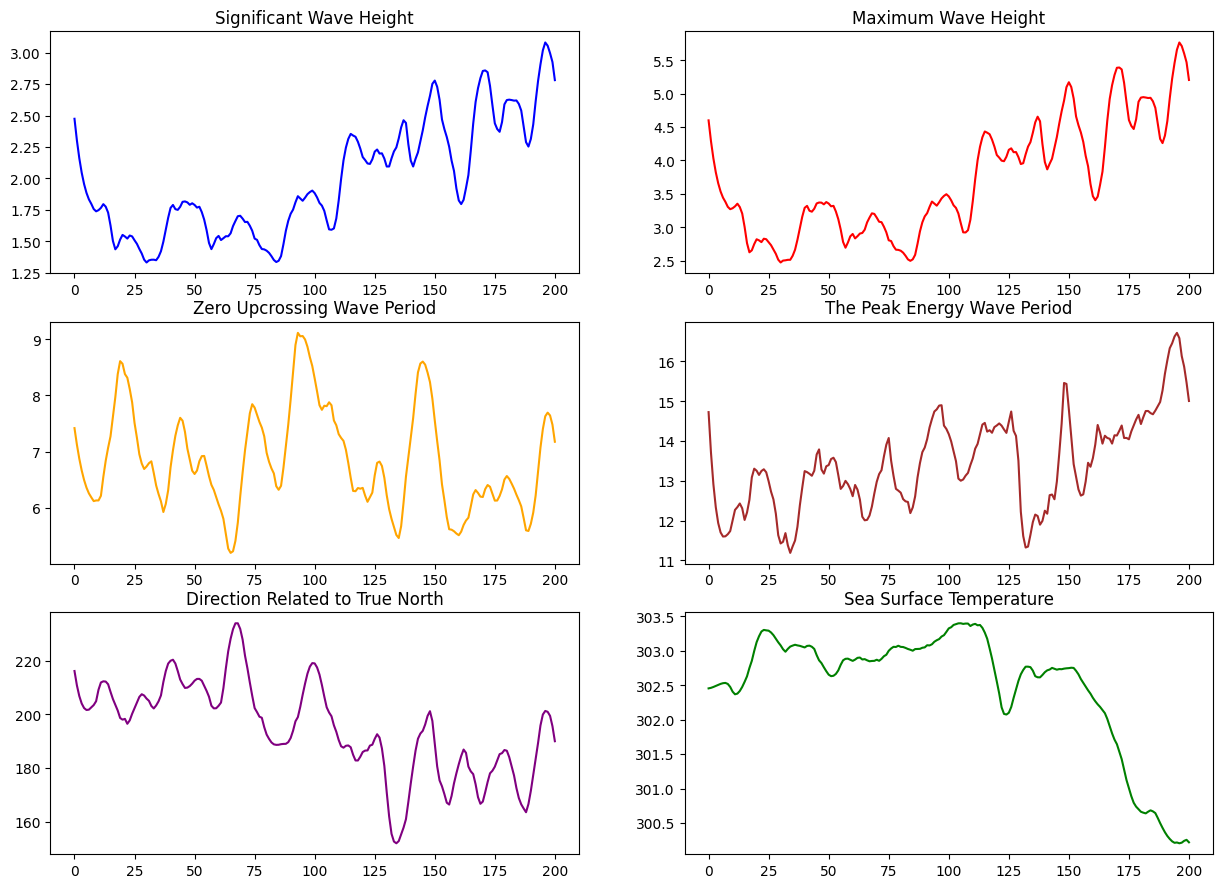

In [9]:
# Plot the Result

df_graph = dataset.loc[0:200]

plt.figure(figsize=(15,22))
plt.subplot(6,2,1)
plt.plot(df_graph['swh_sg'], color='blue')
plt.title('Significant Wave Height')

plt.subplot(6,2,2)
plt.plot(df_graph['hmax_sg'], color='red')
plt.title('Maximum Wave Height')

plt.subplot(6,2,3)
plt.plot(df_graph['mp2_sg'], color='orange')
plt.title('Zero Upcrossing Wave Period')

plt.subplot(6,2,4)
plt.plot(df_graph['pp1d_sg'], color='brown')
plt.title('The Peak Energy Wave Period')

plt.subplot(6,2,5)
plt.plot(df_graph['mwd_sg'], color='purple')
plt.title('Direction Related to True North')

plt.subplot(6,2,6)
plt.plot(df_graph['sst_sg'], color='green')
plt.title('Sea Surface Temperature')
plt.show();

## Initial Statistics

In [10]:
# Show information of dataset
print(dataset.info())

dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   swh_sg   1917 non-null   float32
 1   hmax_sg  1917 non-null   float32
 2   mp2_sg   1917 non-null   float32
 3   pp1d_sg  1917 non-null   float32
 4   mwd_sg   1917 non-null   float32
 5   sst_sg   1917 non-null   float32
dtypes: float32(6)
memory usage: 45.1 KB
None


,swh_sg,hmax_sg,mp2_sg,pp1d_sg,mwd_sg,sst_sg
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000
mean,1.943888,3.636611,6.678473,13.321001,197.933945,301.420715
std,0.375561,0.713197,0.779295,1.177131,18.502945,1.386360
min,1.033822,1.958855,4.643563,9.126506,146.445435,297.406403
25%,1.658900,3.092036,6.131442,12.535130,186.481110,300.571991
50%,1.923732,3.609462,6.646001,13.405335,196.675629,301.949860
75%,2.209273,4.135077,7.192545,14.205815,209.108383,302.445160
max,3.161598,5.926728,9.114713,16.717348,249.681274,303.555939


## Visualisasi Matriks Korelasi

**Fungsi:**
Menampilkan matriks korelasi antar variabel dalam dataset untuk melihat hubungan linear antara fitur-fitur yang sudah di-smooth.

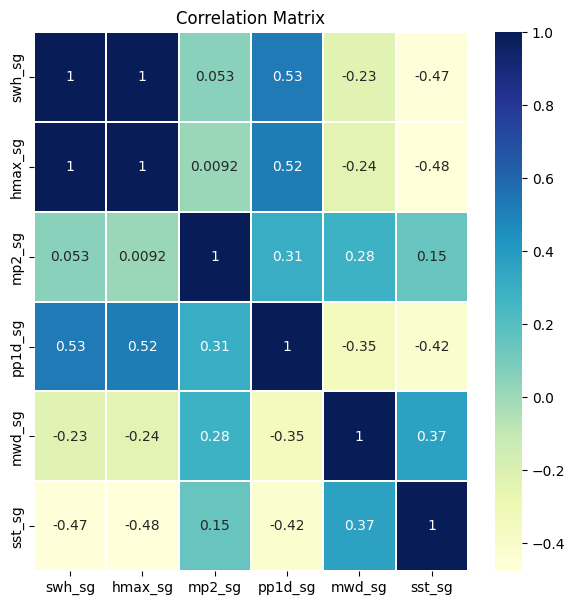

In [11]:
# Plot the Correlation Matrix of Dataset
plt.figure(figsize=(7,7))
sns.heatmap(dataset.corr(), linewidths=.1, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

## Feature Scaling


**Normalisasi Data dengan MinMax Scaler**

**Fungsi:**
Melakukan normalisasi seluruh nilai data ke dalam rentang 0 sampai 1 untuk keseragaman skala antar fitur.

In [12]:
# Scaling all the data valuues into 0-1 range
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(dataset)
print('Shape of data:', data.shape)

Shape of data: (1917, 6)


## Train and Test Split Dataset

**Fungsi:**
Membagi dataset menjadi data training dan testing untuk keperluan pemodelan machine learning.

In [13]:
# Split data into train and test sets
train = data[:1400,]
test = data[1400:,]

# Show of the data shape
print('Shape of train:', train.shape)
print('Shape of test:', test.shape)

Shape of train: (1400, 6)
Shape of test: (517, 6)


## Persiapan Data dalam Batch untuk Pemodelan

**Fungsi:**
Mempersiapkan data dalam bentuk batch yang siap digunakan untuk training dan testing model machine learning/deep learning.


In [14]:
# Create batches of data
X_train, y_train = prepare_data(train, 32)
X_test, y_test = prepare_data(test, 32)

print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape, 'y_test shape:', y_test.shape)

X_train shape: (1367, 6, 32) y_train shape: (1367, 6)
X_test shape: (484, 6, 32) y_test shape: (484, 6)


# Model

## Define The Architecture

**Fungsi:**
Membangun model LSTM (Long Short-Term Memory) untuk memprediksi nilai time series dengan 6 fitur output.

**Penjelasan Kode:**
```python
model = Sequential([
    # Layer LSTM pertama (32 unit) dengan return_sequences=True
    LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # Layer LSTM kedua (16 unit) dengan return_sequences=True
    LSTM(16, return_sequences=True),
    
    # Dropout layer untuk regularisasi (mencegah overfitting)
    Dropout(0.2),
    
    # Layer LSTM ketiga (10 unit) tanpa return_sequences
    LSTM(10),
    
    # Output layer dengan 6 neuron (sesuai jumlah fitur target)
    Dense(6)
])

# Kompilasi model dengan:
# - Optimizer Adam (learning rate 0.001)
# - Loss function MSE (Mean Squared Error)
# - Metrik evaluasi: akurasi
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['accuracy'])

# Menampilkan summary arsitektur model
model.summary()

In [15]:
model = Sequential([
    # First LSTM layer with return_sequences=True because we will add more LSTM layers
    LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(16, return_sequences=True),
    Dropout(0.2),
    LSTM(10),
    Dense(6)  # Output layer with 6 features
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mean_squared_error', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 32)             8320      
                                                                 
 lstm_1 (LSTM)               (None, 6, 16)             3136      
                                                                 
 dropout (Dropout)           (None, 6, 16)             0         
                                                                 
 lstm_2 (LSTM)               (None, 10)                1080      
                                                                 
 dense (Dense)               (None, 6)                 66        
                                                                 
Total params: 12,602
Trainable params: 12,602
Non-trainable params: 0
_________________________________________________________________


## Training

**Fungsi:**
Melatih model LSTM menggunakan data training yang telah dipersiapkan sebelumnya.

In [16]:
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.25,
    verbose=1
)

Epoch 1/300
33/33 [==============================] - 5s 35ms/step - loss: 0.1813 - accuracy: 0.0390 - val_loss: 0.0676 - val_accuracy: 0.1696
Epoch 2/300
33/33 [==============================] - 0s 7ms/step - loss: 0.0410 - accuracy: 0.4205 - val_loss: 0.0457 - val_accuracy: 0.4152
Epoch 3/300
33/33 [==============================] - 0s 6ms/step - loss: 0.0326 - accuracy: 0.5405 - val_loss: 0.0434 - val_accuracy: 0.4152
Epoch 4/300
33/33 [==============================] - 0s 8ms/step - loss: 0.0319 - accuracy: 0.5473 - val_loss: 0.0443 - val_accuracy: 0.4152
Epoch 5/300
33/33 [==============================] - 0s 7ms/step - loss: 0.0317 - accuracy: 0.5629 - val_loss: 0.0430 - val_accuracy: 0.4152
Epoch 6/300
33/33 [==============================] - 0s 6ms/step - loss: 0.0311 - accuracy: 0.5620 - val_loss: 0.0434 - val_accuracy: 0.4152
Epoch 7/300
33/33 [==============================] - 0s 6ms/step - loss: 0.0314 - accuracy: 0.5571 - val_loss: 0.0436 - val_accuracy: 0.4152
Epoch 8/300


## Plot the Accuracy and Loss

**Fungsi:**
Memvisualisasikan performa model selama proses training dengan menampilkan grafik akurasi dan loss untuk data training dan validasi.

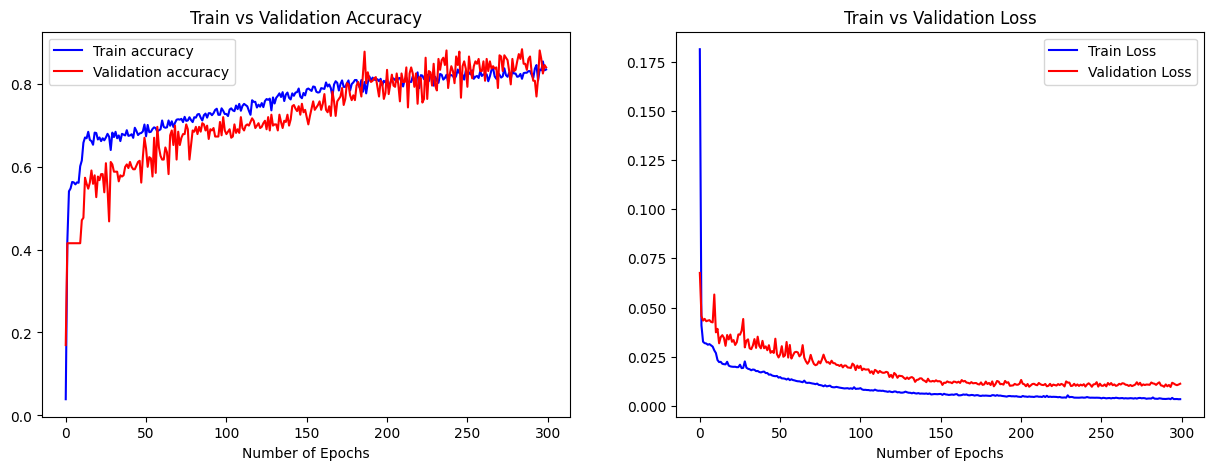

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], color='blue', label='Train accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='Validation accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='blue', label='Train Loss')
plt.plot(history.history['val_loss'], color='red', label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.show();

## Prediction
**Fungsi:**
Melakukan prediksi menggunakan model yang telah dilatih dan mengembalikan data ke skala aslinya.


In [18]:
pred_data = model.predict(X_test)
pred_data = scaler.inverse_transform(pred_data)
y_test = scaler.inverse_transform(y_test)


16/16 [==============================] - 1s 2ms/step


# Evaluating the Model
**Fungsi:**
Menghitung dan menampilkan Root Mean Square Error (RMSE) antara nilai prediksi dan nilai aktual untuk mengukur akurasi model.


In [19]:
print('Test Data Error')
print(rmse_calculation(y_test, pred_data))

Test Data Error
RMSE of swh: 7.241265132235667
RMSE of hmax: 0.1464216479465677
RMSE of mp2: 0.27455753092065055
RMSE of pp1d: 0.6442985808293369
RMSE of mwd: 0.39695142851093307
RMSE of sst: 0.6253961023189712
None


## Plot Result of Prediction

**Fungsi:**
Memvisualisasikan hasil prediksi model terhadap nilai sebenarnya untuk semua fitur output dalam bentuk time series plot.

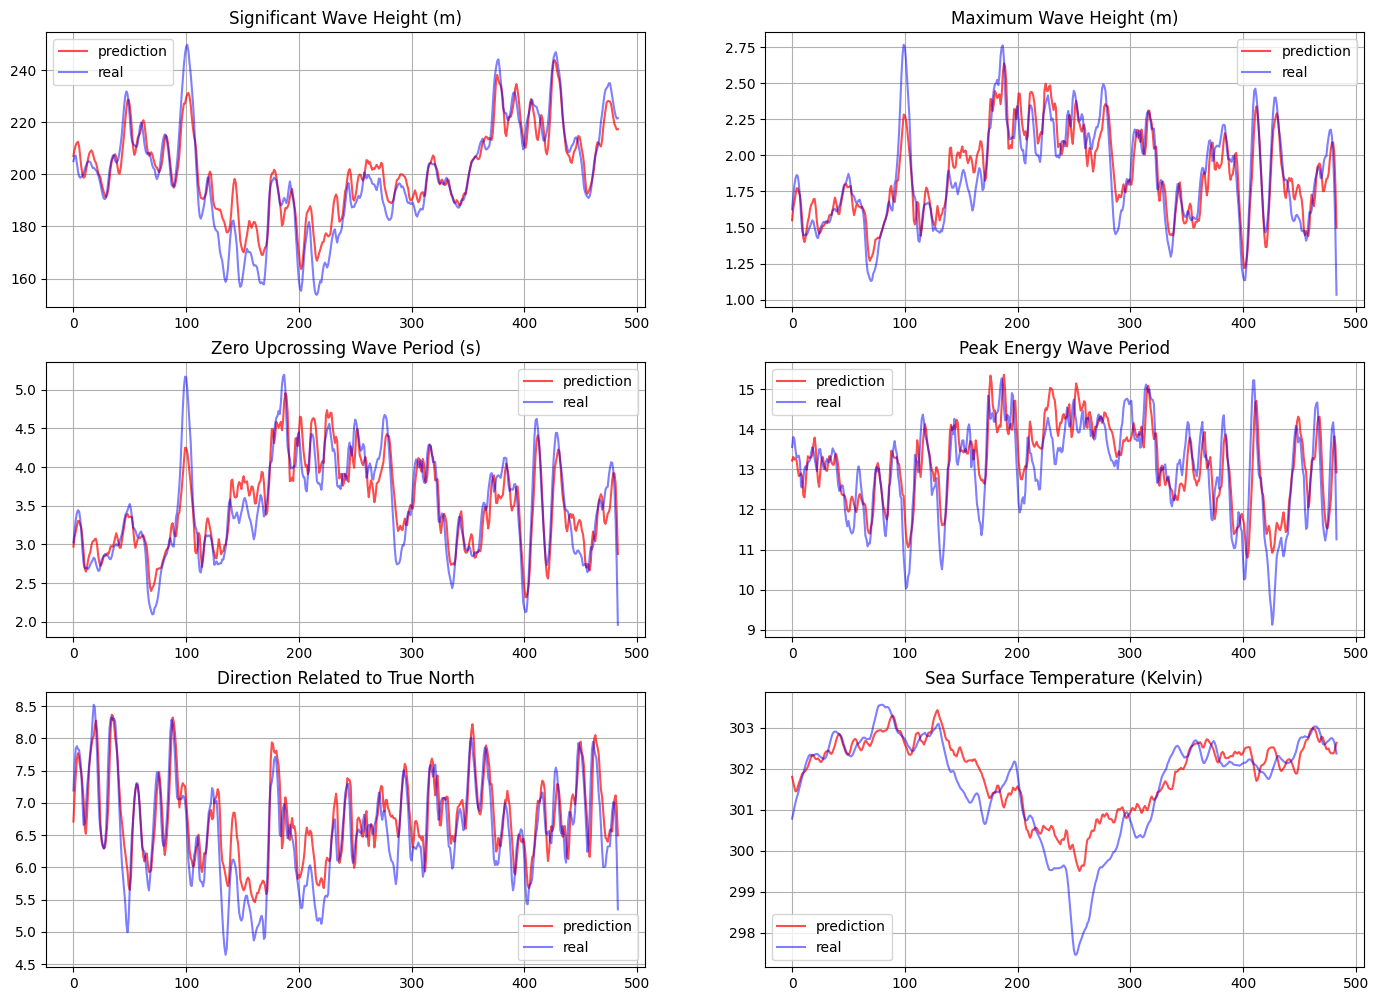

In [20]:
plt.figure(figsize=(17,25))


plt.subplot(6,2,1)
plt.plot(pred_data[:,4], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[:,4], color='blue', alpha=0.5, label='real')
plt.title('Significant Wave Height (m)')
plt.legend()
plt.grid()

plt.subplot(6,2,2)
plt.plot(pred_data[:,0], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[:,0], color='blue', alpha=0.5, label='real')
plt.title('Maximum Wave Height (m)')
plt.legend()
plt.grid()

plt.subplot(6,2,3)
plt.plot(pred_data[:,1], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[:,1], color='blue', alpha=0.5, label='real')
plt.title('Zero Upcrossing Wave Period (s)')
plt.legend()
plt.grid()

plt.subplot(6,2,4)
plt.plot(pred_data[:,3], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[:,3], color='blue', alpha=0.5, label='real')
plt.title('Peak Energy Wave Period')
plt.legend()
plt.grid()

plt.subplot(6,2,5)
plt.plot(pred_data[:,2], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[:,2], color='blue', alpha=0.5, label='real')
plt.title('Direction Related to True North')
plt.legend()
plt.grid()

plt.subplot(6,2,6)
plt.plot(pred_data[:,5], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[:,5], color='blue', alpha=0.5, label='real')
plt.title('Sea Surface Temperature (Kelvin)')
plt.legend()
plt.grid()
plt.show();